# PyTorch Workflow

Exploring an end-to-end PyTorch workflow.

I utilise the following resources:

1. https://github.com/mrdbourke/pytorch-deep-learning/blob/main/01_pytorch_workflow.ipynb
2. https://www.learnpytorch.io/01_pytorch_workflow/

<img src="https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/01_a_pytorch_workflow.png" width=900 alt="a pytorch workflow flowchat"/>

In [ ]:
import torch
from torch import nn # PyTorch's building blocks https://pytorch.org/docs/stable/nn.html
import matplotlib.pyplot as plt
import numpy as np

# PyTorch Version
torch.__version__

'2.6.0+cu124'

## 1. Data (preparing and loading).

Two main ideas are:
1. Get data into a numerical representation.
2. Build a model to learn patterns in that numerical representation.

<img src=https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/01-machine-learning-a-game-of-two-parts.png
width=900 alt="a game of 2 parts"/>

To showcase these steps we can generate some dummy data using the linear regression formula.

Using linear regressuion we'll make a stright line with known **parameters**.


In [ ]:
# Creating known parameters

bias = 0.3
weight = 0.7

start = 0
end = 1
step = 0.02

X = torch.arange(start, end, step).unsqueeze(dim=1) #the unsqueeze is important later for model building

y = weight*X + bias

X, y

(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800],
         [0.1000],
         [0.1200],
         [0.1400],
         [0.1600],
         [0.1800],
         [0.2000],
         [0.2200],
         [0.2400],
         [0.2600],
         [0.2800],
         [0.3000],
         [0.3200],
         [0.3400],
         [0.3600],
         [0.3800],
         [0.4000],
         [0.4200],
         [0.4400],
         [0.4600],
         [0.4800],
         [0.5000],
         [0.5200],
         [0.5400],
         [0.5600],
         [0.5800],
         [0.6000],
         [0.6200],
         [0.6400],
         [0.6600],
         [0.6800],
         [0.7000],
         [0.7200],
         [0.7400],
         [0.7600],
         [0.7800],
         [0.8000],
         [0.8200],
         [0.8400],
         [0.8600],
         [0.8800],
         [0.9000],
         [0.9200],
         [0.9400],
         [0.9600],
         [0.9800]]),
 tensor([[0.3000],
         [0.3140],
         [

### Splitting data into training and testing set
creating a training and test set with our data.

In [ ]:
# Create a test/train split
train_split = int(0.8 * len(X))

X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]

In [ ]:
len(X_train), len(y_train), len(X_test), len(y_test)

(40, 40, 10, 10)

### Visualising

In [ ]:
def plot_predictions(train_data = X_train, train_label = y_train,
                     test_data = X_test, test_label = y_test,
                     predictions = None):
  """ Plots the train/test data and compares predictions. Outputs 1 Graph. """

  #Plot training data
  plt.scatter(train_data, train_label, c= "b", s = 4, label = "Training Data")

  #Plot testing data
  plt.scatter(X_test, y_test, c="g", s=4, label = "Testing Data")

  if predictions is not None:
    plt.scatter(test_data, predictions, c = "r", s=4, label = "Predictions")

  #Show Legend
  plt.legend(prop={"size": 14})

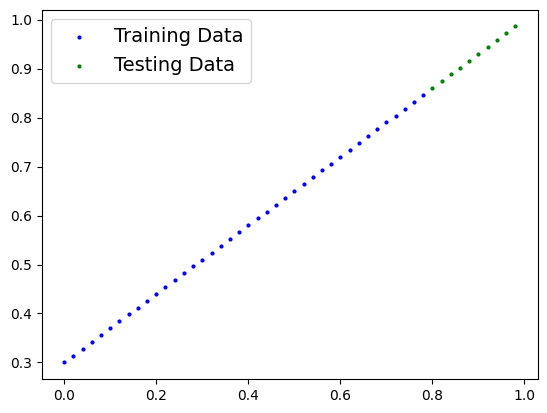

In [ ]:
plot_predictions()

## 2. Build Model
First PyTorch Model

In [ ]:
class LinearRegressionModel(nn.Module): #inherits from nn.Module
  def __innit__(self):
    super().__innit__()
    self.weights = nn.Parameter(torch.rand(1,
                              requires_grad = True,
                              dtype = torch.float))

    self.bias = nn.Parameter(torch.rand(1,
                           requires_grad= True,
                           dtype = torch.float))
    # Forward method
    def forward(self, x: torch.Tensor) -> torch.tensor: # <- "x" is the input data
      return self.weights*x + self.bias #this is the linear regression formula


